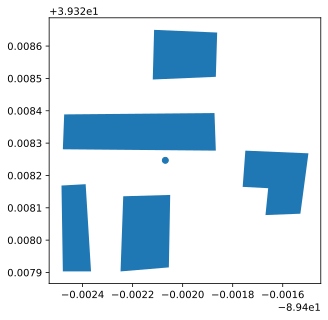

In [43]:
import numpy as np
import pandas as pd
import time
import h5pyd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import geometry
import os

from dw_tap.process_geojson import get_obstacles
from dw_tap.data_fetching import getData
from dw_tap.process_geojson import get_candidate
from dw_tap.lom import run_lom
from dw_tap.power_output import estimate_power_output

%config InlineBackend.figure_format = 'svg'

obstacle_file ="../sites/180-5BuildingsManual.geojson"
df_places = gpd.read_file(obstacle_file)
# Leave in only relevant columns
df_places = df_places[["height", "geometry"]]

ax=df_places.geometry.plot()

# Need to use better projection
# source of solution: https://gis.stackexchange.com/questions/372564/userwarning-when-trying-to-get-centroid-from-a-polygon-geopandas
df_places_centroid = df_places.dissolve().to_crs('+proj=cea').centroid.to_crs(df_places.crs)
df_places_centroid.geometry.plot(ax=ax);

In [44]:
# Creating the grid over site

# Here using 1 degree = 111,000m -- 
# This crude approx should be an appropriate option for point generation
m_per_deg = 111000

site_box_width_m = 1000
site_box_height_m = 1000

# halfs of box / dimensions
lon_delta = (site_box_width_m / m_per_deg ) / 2.0
lat_delta = (site_box_height_m / m_per_deg ) / 2.0

df_places_centroid.geometry.x, df_places_centroid.geometry.y
#print(lon_delta, lat_delta)

lon_n, lat_n = (4, 4)
x = np.linspace(df_places_centroid.geometry.x-lon_delta, 
                df_places_centroid.geometry.x+lon_delta, 
                lon_n)
y = np.linspace(df_places_centroid.geometry.y-lat_delta, 
                df_places_centroid.geometry.y+lat_delta, 
                lat_n)
xv, yv = np.meshgrid(x, y)
#xv, yv

/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_38140/1429394866.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  inside_polygons_index = gpd.sjoin(gridpoints, df_places, op='within').index


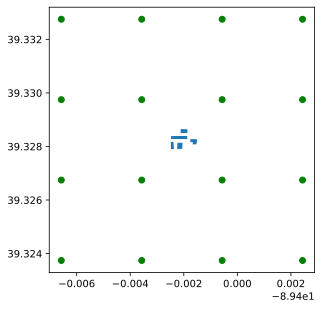

In [45]:
# plotting using two arrays, xv and yv, created by meshgrid()
# Probably not the best format for exluding points that fall inside the buildings 

#ax=df_places.geometry.plot()
#df_places_centroid.geometry.plot(ax=ax);
#ax.plot(xv, yv, ls="None", marker=".");
#plt.show()

gridpoints = gpd.GeoDataFrame(
    {"geometry": [geometry.Point(el) for el in zip(xv.flatten(), yv.flatten())]})
#gridpoints.plot();

inside_polygons_index = gpd.sjoin(gridpoints, df_places, op='within').index
outside_polygons_index = [i for i in gridpoints.index if i not in inside_polygons_index]
gridpoints_outside_polygons = gridpoints.loc[outside_polygons_index]

ax=df_places.geometry.plot()
#df_places_centroid.geometry.plot(ax=ax);

#ax.plot(xv, yv, ls="None", marker=".");
gridpoints_outside_polygons.plot(color="green", ax=ax)
plt.show()

In [46]:
gridpoints_outside_polygons

,geometry
0,POINT (-89.40657 39.32374)
1,POINT (-89.40357 39.32374)
2,POINT (-89.40057 39.32374)
3,POINT (-89.39756 39.32374)
4,POINT (-89.40657 39.32675)
5,POINT (-89.40357 39.32675)
6,POINT (-89.40057 39.32675)
7,POINT (-89.39756 39.32675)
8,POINT (-89.40657 39.32975)
9,POINT (-89.40357 39.32975)


In [47]:
# Open the wind data "file"
# server endpoint, username, password is found via a config file
f = h5pyd.File("/nrel/wtk-us.h5", 'r', bucket="nrel-pds-hsds") 

# quick test of HSDS
z_turbine = 40
x = getData(f, 
            39.32856, 
            -89.40238, 
            z_turbine, "IDW", True, 
            start_time_idx=0, end_time_idx=20, time_stride=1)
x

,datetime,ws,wd,temp,pres
0,2007-01-01 00:00:00,7.744876,232.969856,282.541870,98493.965337
1,2007-01-01 01:00:00,8.300953,238.699807,281.693481,98495.460733
2,2007-01-01 02:00:00,7.133009,231.615181,280.445251,98537.836735
3,2007-01-01 03:00:00,8.410358,237.254853,279.526672,98551.378019
4,2007-01-01 04:00:00,8.571108,237.999669,278.693512,98555.189398
5,2007-01-01 05:00:00,9.677198,264.083083,277.466644,98606.202935
6,2007-01-01 06:00:00,7.855240,249.504717,275.260162,98683.896769
7,2007-01-01 07:00:00,8.032872,251.424083,274.045532,98764.044204
8,2007-01-01 08:00:00,7.826284,251.236428,273.410736,98804.868021
9,2007-01-01 09:00:00,8.237046,259.152875,273.010956,98861.000777


In [51]:
df_places

,height,geometry
0,10,"POLYGON ((-89.40211 39.32865, -89.40212 39.328..."
1,10,"POLYGON ((-89.40247 39.32839, -89.40248 39.328..."
2,10,"POLYGON ((-89.40248 39.32817, -89.40248 39.327..."
3,10,"POLYGON ((-89.40224 39.32814, -89.40225 39.327..."
4,10,"POLYGON ((-89.40175 39.32828, -89.40176 39.328..."


In [49]:
xy_turbine

[array([-89.40056775,  39.32374225])]

In [50]:
[np.array([lon, lat])]

[array([-89.40056775,  39.32374225])]

In [52]:
# New way of creating a summary dataframe, one quantity at a time; NO LOM

# Replace old files or not
overwrite = True

z_turbine = 40   
obstacles_df = df_places   

output_dest = "../output/heatmap-180/"
if not os.path.exists(output_dest):
    os.makedirs(output_dest)

gridpoints_outside_polygons["ws"] = None
gridpoints_outside_polygons["wd"] = None

summary_df_cols = ["geometry", "time_period", 
                   "khw_without_lom", "khw_with_lom", "kwh_delta", 
                   "ts_file_path"]
summary_df = pd.DataFrame(columns=summary_df_cols)
summary_df_path = os.path.join(output_dest, "summary.csv")

if os.path.exists(summary_df_path):
    summary_df = pd.read_csv(summary_df_path)

for idx in gridpoints_outside_polygons[2:].index:
    
    
    lat, lon = gridpoints_outside_polygons.at[idx, "geometry"].y, gridpoints_outside_polygons.at[idx, "geometry"].x
    print("Estimating for: (%.3f, %.3f)" % (lat, lon))
    
    lat_lon_label = str(lat) + "_" + str(lon)
    #print(lat_lon_label)
    
    ts_df_path = os.path.join(output_dest, lat_lon_label + ".csv")
    #print(ts_df_path)
    
    if os.path.exists(ts_df_path) and (not overwrite):
        print("This point was already processed. Skipping to the next one (overwrite flag is off)")
        continue

    atmospheric_df = getData(f, 
                             lat, 
                             lon, 
                             z_turbine, "IDW", True, 
                             start_time_idx=0, end_time_idx=2000, time_stride=1) # 0, 4380, 1) # year: 8760; Quick test: 0, 2000, 200)
    print("Done with data fetching for the point.")
    
    time_period = str(atmospheric_df["datetime"][0]) + " - " + str(atmospheric_df["datetime"][len(atmospheric_df)-1])
    
    #gridpoints_outside_polygons.at[idx, "ws"] = ws.tolist()
    #gridpoints_outside_polygons.at[idx, "wd"] = theta.tolist()
    
    xy_turbine = [np.array([lon, lat])]
    
    break
    
    predictions_df = \
        run_lom(atmospheric_df, obstacles_df, xy_turbine, z_turbine,
               check_distance=True)
    
    print("Avg. ws deficit (m/s):", (predictions_df["ws"] - predictions_df["ws-adjusted"]).mean())
    
    time_powerOutput0 = time.time()

    kw_ts_with_lom, above_curve, below_curve, above_curve_list, below_curve_list = \
        estimate_power_output(predictions_df, atmospheric_df['temp'], atmospheric_df['pres'],
                              ws_column="ws-adjusted")  
    kwh_total_with_lom = kw_ts_with_lom.sum()
    
    kw_ts_without_lom, above_curve, below_curve, above_curve_list, below_curve_list = \
        estimate_power_output(predictions_df, atmospheric_df['temp'], atmospheric_df['pres'],
                              ws_column="ws")  
    kwh_total_without_lom = kw_ts_without_lom.sum()
    
    print("Total kWh (with and without LOM):", kwh_total_with_lom, kwh_total_without_lom)
    
    #for t, ws_v, wd_v, kw_v in zip(dates, ws, theta, kw):
    #    gridpoints_df.loc[len(gridpoints_df)] = [gridpoints_outside_polygons.at[idx, "geometry"], t, "windspeed", ws_v]
    #    gridpoints_df.loc[len(gridpoints_df)] = [gridpoints_outside_polygons.at[idx, "geometry"], t, "winddirection", wd_v]
    #    gridpoints_df.loc[len(gridpoints_df)] = [gridpoints_outside_polygons.at[idx, "geometry"], t, "kw", kw_v]  
    
    #gridpoints_df.loc[len(gridpoints_df)] = [gridpoints_outside_polygons.at[idx, "geometry"], "Total", "kwh_total_without_lom", kw_total_without_lom]
    #gridpoints_df.loc[len(gridpoints_df)] = [gridpoints_outside_polygons.at[idx, "geometry"], "Total", "kwh_total_with_lom", kw_total_with_lom]
    #gridpoints_df.loc[len(gridpoints_df)] = [gridpoints_outside_polygons.at[idx, "geometry"], "Total", "kwh_diff", kw_total_without_lom - kw_total_with_lom]
    
    summary_df.loc[len(summary_df)] = [gridpoints_outside_polygons.at[idx, "geometry"],
                                       time_period,
                                       kwh_total_without_lom,
                                       kwh_total_with_lom,
                                       kwh_total_without_lom - kwh_total_with_lom,
                                       ts_df_path]
    
    ts_df = pd.DataFrame({"datetime": atmospheric_df["datetime"],
                          "ws": atmospheric_df["ws"],
                          "wd": atmospheric_df["wd"],
                          "ws-adjusted": predictions_df["ws-adjusted"],
                          "kw_ts_without_lom": kw_ts_without_lom,
                          "kw_ts_with_lom": kw_ts_with_lom})
    
    summary_df.to_csv(summary_df_path, index=False)
    ts_df.to_csv(ts_df_path, index=False)
                                           
    break

#gridpoints_df

Estimating for: (39.324, -89.401)
Done with data fetching for the point.


In [54]:
atmospheric_df.to_csv("../data/180_2000rows_under_review.csv", index=False)

In [55]:
xy_turbine = [np.array([lon, lat])]
xy_turbine

[array([-89.40056775,  39.32374225])]

In [27]:
obstacles_df

,stroke,stroke-width,stroke-opacity,fill,fill-opacity,height,geometry
0,#555555,2,1,#555555,0.5,10,"POLYGON ((-89.40211 39.32865, -89.40212 39.328..."
1,#555555,2,1,#555555,0.5,10,"POLYGON ((-89.40247 39.32839, -89.40248 39.328..."
2,#555555,2,1,#555555,0.5,10,"POLYGON ((-89.40248 39.32817, -89.40248 39.327..."
3,#555555,2,1,#555555,0.5,10,"POLYGON ((-89.40224 39.32814, -89.40225 39.327..."
4,#555555,2,1,#555555,0.5,10,"POLYGON ((-89.40175 39.32828, -89.40176 39.328..."


In [28]:
predictions_df

,timestamp,ws,ws-adjusted
0,2007-01-01 00:00:00,7.787228,7.771351
1,2007-01-01 01:00:00,8.213125,8.204848
2,2007-01-01 02:00:00,7.102716,7.086054
3,2007-01-01 03:00:00,8.614593,8.604501
4,2007-01-01 04:00:00,8.448002,8.437731
...,...,...,...
1996,2007-03-25 04:00:00,7.438345,4.948845
1997,2007-03-25 05:00:00,7.546097,6.748088
1998,2007-03-25 06:00:00,6.790068,5.588145
1999,2007-03-25 07:00:00,6.690274,5.815833


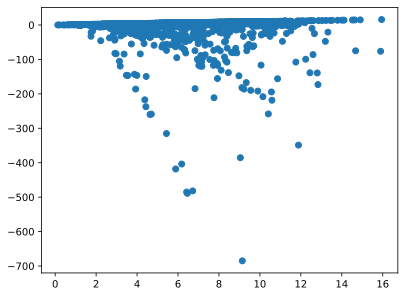

In [30]:
tmp = predictions_df # [predictions_df["nonlinear"] > 0]

import matplotlib.pyplot as plt
plt.scatter(tmp["ws"], tmp["ws-adjusted"])

In [36]:
#ax = kw_ts_with_lom.cumsum().plot(linewidth=8.0); #ylabel="Cumulative kWh produced", xlabel="Time");
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)

In [43]:
summary_df

,geometry,time_period,khw_without_lom,khw_with_lom,kwh_delta,ts_file_path
0,POINT (-89.40652951922961 39.32368248594488),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9211.009851,9169.033153,41.976699,../output/heatmap-180/39.32368248594488_-89.40...
1,POINT (-89.40552851822861 39.32368248594488),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9217.581277,9195.320340,22.260937,../output/heatmap-180/39.32368248594488_-89.40...
2,POINT (-89.40452751722761 39.32368248594488),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9224.253996,9211.449644,12.804352,../output/heatmap-180/39.32368248594488_-89.40...
3,POINT (-89.40352651622661 39.32368248594488),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9239.326689,9232.843012,6.483677,../output/heatmap-180/39.32368248594488_-89.40...
4,POINT (-89.40252551522561 39.32368248594488),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9251.504556,9247.585865,3.918691,../output/heatmap-180/39.32368248594488_-89.40...
...,...,...,...,...,...,...
95,POINT (-89.40152451422459 39.33269149495388),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9090.465671,9083.761421,6.704250,../output/heatmap-180/39.332691494953885_-89.4...
96,POINT (-89.40052351322359 39.33269149495388),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9089.812921,9077.452834,12.360087,../output/heatmap-180/39.332691494953885_-89.4...
97,POINT (-89.39952251222259 39.33269149495388),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9089.205065,9066.187296,23.017770,../output/heatmap-180/39.332691494953885_-89.3...
98,POINT (-89.39852151122159 39.33269149495388),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9088.673428,9042.503592,46.169836,../output/heatmap-180/39.332691494953885_-89.3...


In [67]:
print(type(summary_df.geometry[0]))
print(type(summary_df.geometry[len(summary_df)-1]))

<class 'str'>
<class 'shapely.geometry.point.Point'>


In [70]:
import shapely.wkt

# Convert strings (possibly loaded from saved file) to shapely point objects
for idx in summary_df.index:
    el = summary_df["geometry"][idx]
    if type(el) == type("string"):
        summary_df["geometry"][idx] = shapely.wkt.loads(el)

/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_80586/3000407011.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_df["geometry"][idx] = shapely.wkt.loads(el)


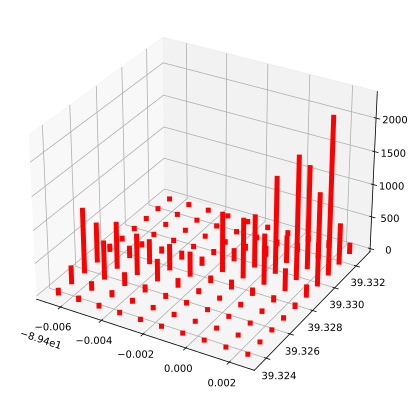

In [71]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

x_, y_, z_ = [el.x for el in summary_df.geometry], \
             [el.y for el in summary_df.geometry], \
              summary_df.kwh_delta.tolist()

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

for el_x, el_y, el_z in zip(x_, y_, z_):
    ax.plot3D([el_x, el_x], [el_y, el_y], [0, el_z], 'red', linewidth=5.0)

plt.show()

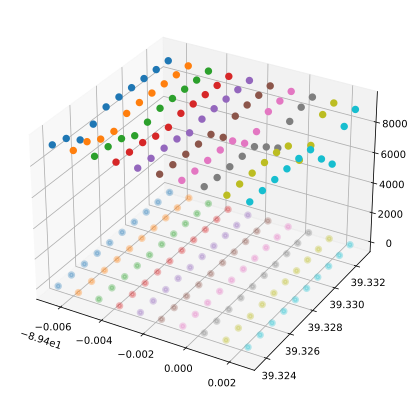

In [73]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

x_, y_, z_ = [el.x for el in summary_df.geometry], \
             [el.y for el in summary_df.geometry], \
              summary_df.khw_with_lom.tolist()

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

for el_x, el_y, el_z in zip(x_, y_, z_):
    ax.scatter3D([el_x, el_x], [el_y, el_y], [0, el_z], 'blue', linewidth=3.0)

plt.show()

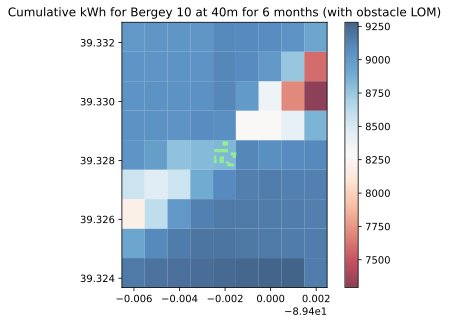

In [124]:
# following code is based on example from: https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap

import matplotlib.pyplot as plt
import numpy as np

x_, y_, z_ = [el.x for el in summary_df.geometry], \
             [el.y for el in summary_df.geometry], \
              summary_df.khw_with_lom.tolist()

# generate 2 2d grids for the x & y bounds
y, x = np.array(y_).reshape(10,-1), np.array(x_).reshape(10,-1)

z = np.array(z_).reshape(10,-1)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = np.abs(z).min(), np.abs(z).max()

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max, alpha=0.75)
ax.set_title('Cumulative kWh for Bergey 10 at 40m for 6 months (with obstacle LOM)')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

df_places.geometry.plot(color='lightgreen', ax=ax)

plt.show()

In [126]:
(np.abs(z).max() - np.abs(z).min()) / np.abs(z).max() * 100

21.43365795417006

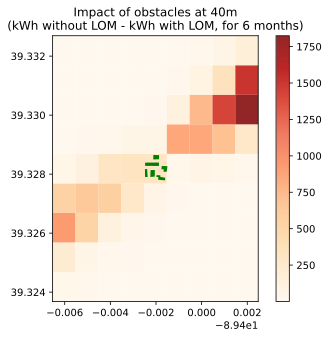

In [121]:
# following code is based on example from: https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap

import matplotlib.pyplot as plt
import numpy as np

x_, y_, z_ = [el.x for el in summary_df.geometry], \
             [el.y for el in summary_df.geometry], \
              summary_df.kwh_delta.tolist()

# generate 2 2d grids for the x & y bounds
y, x = np.array(y_).reshape(10,-1), np.array(x_).reshape(10,-1)

z = np.array(z_).reshape(10,-1)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = np.abs(z).min(), np.abs(z).max()

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap='OrRd', vmin=z_min, vmax=z_max, alpha=0.85)
ax.set_title('Impact of obstacles at 40m\n(kWh without LOM - kWh with LOM, for 6 months)')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

df_places.geometry.plot(color='green', ax=ax)

plt.show()

In [127]:
summary_df

,geometry,time_period,khw_without_lom,khw_with_lom,kwh_delta,ts_file_path
0,POINT (-89.40652951922961 39.32368248594488),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9211.009851,9169.033153,41.976699,../output/heatmap-180/39.32368248594488_-89.40...
1,POINT (-89.40552851822861 39.32368248594488),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9217.581277,9195.320340,22.260937,../output/heatmap-180/39.32368248594488_-89.40...
2,POINT (-89.40452751722761 39.32368248594488),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9224.253996,9211.449644,12.804352,../output/heatmap-180/39.32368248594488_-89.40...
3,POINT (-89.40352651622661 39.32368248594488),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9239.326689,9232.843012,6.483677,../output/heatmap-180/39.32368248594488_-89.40...
4,POINT (-89.40252551522561 39.32368248594488),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9251.504556,9247.585865,3.918691,../output/heatmap-180/39.32368248594488_-89.40...
...,...,...,...,...,...,...
95,POINT (-89.40152451422459 39.33269149495388),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9090.465671,9083.761421,6.704250,../output/heatmap-180/39.332691494953885_-89.4...
96,POINT (-89.40052351322359 39.33269149495388),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9089.812921,9077.452834,12.360087,../output/heatmap-180/39.332691494953885_-89.4...
97,POINT (-89.39952251222259 39.33269149495388),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9089.205065,9066.187296,23.017770,../output/heatmap-180/39.332691494953885_-89.3...
98,POINT (-89.39852151122159 39.33269149495388),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9088.673428,9042.503592,46.169836,../output/heatmap-180/39.332691494953885_-89.3...


In [128]:
ts_df

,datetime,ws,wd,ws-adjusted,kw_ts_without_lom,kw_ts_with_lom
0,2007-01-01 00:00:00,7.785012,233.034954,7.740231,3.291859,3.233544
1,2007-01-01 01:00:00,8.297718,238.696513,8.250855,3.999197,3.933337
2,2007-01-01 02:00:00,7.203153,231.841675,7.161604,2.622774,2.577415
3,2007-01-01 03:00:00,8.337746,236.997656,8.290358,4.087871,4.021089
4,2007-01-01 04:00:00,8.637312,238.298787,8.588455,4.541054,4.466161
...,...,...,...,...,...,...
4376,2007-07-02 08:00:00,6.459177,91.566366,6.459177,1.860805,1.860805
4377,2007-07-02 09:00:00,6.591325,91.791790,6.591325,1.982253,1.982253
4378,2007-07-02 10:00:00,6.412947,97.639996,6.412947,1.829223,1.829223
4379,2007-07-02 11:00:00,6.686869,102.191243,6.686869,2.076989,2.076989


In [131]:
summary_df.iloc[50].ts_file_path

'../output/heatmap-180/39.32868749094988_-89.40652951922961.csv'

In [132]:
ts_df_for_middle = pd.read_csv('../output/heatmap-180/39.32868749094988_-89.40652951922961.csv')

In [133]:
ts_df_for_middle

,datetime,ws,wd,ws-adjusted,kw_ts_without_lom,kw_ts_with_lom
0,2007-01-01 00:00:00,7.664650,231.612594,7.664650,3.135464,3.135464
1,2007-01-01 01:00:00,8.189462,238.231211,8.189462,3.847463,3.847463
2,2007-01-01 02:00:00,7.134345,232.281767,7.134345,2.547986,2.547986
3,2007-01-01 03:00:00,8.311078,237.648856,8.311078,4.050688,4.050688
4,2007-01-01 04:00:00,8.564693,237.837481,8.564693,4.430197,4.430197
...,...,...,...,...,...,...
4376,2007-07-02 08:00:00,6.461884,90.337806,6.454384,1.863267,1.856896
4377,2007-07-02 09:00:00,6.561321,90.668206,6.553680,1.954710,1.947651
4378,2007-07-02 10:00:00,6.346073,96.557849,6.338238,1.772506,1.765841
4379,2007-07-02 11:00:00,6.651165,100.878888,6.642653,2.044151,2.036279
